# VARMAX model

**With the StatsModel API, build a VARMA model using the `VARMAX()` function. The dataset for this exercise contains the monthly temperatures for several major cities in eight countries, e.g. Auckland or Stockholm. The rows of values for each city are stacked on top of each other, rather than each city being reported on next to each other. However, this also means that the dates are repeated for each city. Separate out two cities and their average temperatures as individual time series for the model (you can pick three cities but no more), and then you can set the dates as the index.**

**NOTE: The dates are entered as DataFrame columns, 'month', 'day' and 'year', so the values must be combined into the proper format and parsed as `datetime` datatype.**

**NOTE: There are some null values in the multiple time series that should be removed or imputed.**

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.api import VAR
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv('data/temperature.csv')

In [4]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E


In [5]:
df['City'].value_counts()

City
Odesa           3214
Paris           3210
Kherson         3209
Wroclaw         3208
Kiev            3208
Lvov            3207
Stockholm       3207
Warsaw          3203
Marseille       3202
Uppsala         3201
Canoas          2157
Brasília        2156
Tottori         2056
Tokyo           2001
Hamilton        1914
Auckland        1912
Cape Town       1866
Johannesburg    1855
Name: count, dtype: int64

In [6]:
# Function to re-format and parse the dates

def parse_date(row):
    s = f"{row['year']}-{row['month']}-{row['day']}" 
    return datetime.strptime(s, "%Y-%m-%d")

In [7]:
# Apply function to every row

df['Date'] = df.apply(parse_date, axis=1)

In [8]:
df.head()

,record_id,month,day,year,AverageTemperatureFahr,AverageTemperatureUncertaintyFahr,City,country_id,Country,Latitude,Longitude,Date
0,474376,1,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-01-01
1,474377,2,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-02-01
2,474378,3,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-03-01
3,474379,4,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-04-01
4,474380,5,1,1853,NaN,NaN,Auckland,NEW,New Zealand,36.17S,175.03E,1853-05-01


In [9]:
# Select two cities (far away geographically)

auckland = df[df['City'] == 'Auckland'].copy().dropna()

stockholm = df[df['City'] == 'Stockholm'].copy().dropna()

In [10]:
# Keep only columns you want

auckland = auckland[['Date', 'AverageTemperatureFahr']].copy()

stockholm = stockholm[['Date', 'AverageTemperatureFahr']].copy()

In [11]:
# Set date col as index for Auckland

auckland.set_index(auckland['Date'], inplace=True)
auckland.drop('Date', axis=1, inplace=True)
auckland.columns = ['AucklandTemp']

In [12]:
auckland.head()

,AucklandTemp
Date,
1853-06-01,51.9062
1853-07-01,52.3886
1853-08-01,52.8530
1853-09-01,52.5776
1853-10-01,54.8726


In [13]:
# Set date col as index for Stockholm

stockholm.set_index(stockholm['Date'], inplace=True)
stockholm.drop('Date', axis=1, inplace=True)
stockholm.columns = ['StockholmTemp']

In [14]:
stockholm.head()

,StockholmTemp
Date,
1743-11-01,42.8414
1744-04-01,36.8888
1744-05-01,45.1220
1744-06-01,53.1824
1744-07-01,60.0260


In [15]:
# Join Auckland & Stockholm temps - has some missing data

joined = auckland.join(stockholm, how='outer') 

In [16]:
joined.shape

(3155, 2)

In [19]:
joined.head()

,AucklandTemp,StockholmTemp
Date,,
1743-11-01,NaN,42.8414
1744-04-01,NaN,36.8888
1744-05-01,NaN,45.1220
1744-06-01,NaN,53.1824
1744-07-01,NaN,60.0260


In [17]:
# At least 40% of Auckland data is null because dates are not the same

joined.isna().sum()

AucklandTemp     1249
StockholmTemp      19
dtype: int64

**3,155 rows of data is a lot for a VARMA model, and since there are a lot of null values, it would better to break off the last part of the data to build the model. 500 rows is enough to represent approx. 40 years of data.**

In [18]:
# Break off last 500 rows of data
joined_part = joined.iloc[-500:].copy()

# Set index frequency
joined_part.index.freq = 'MS'

In [19]:
# Check null values

joined_part.isna().sum()

AucklandTemp     1
StockholmTemp    4
dtype: int64

In [20]:
# Impute missing temp values using linear interpolation

joined_part.interpolate(inplace=True)

In [21]:
# Now all null values gone

joined_part.isna().sum()

AucklandTemp     0
StockholmTemp    0
dtype: int64

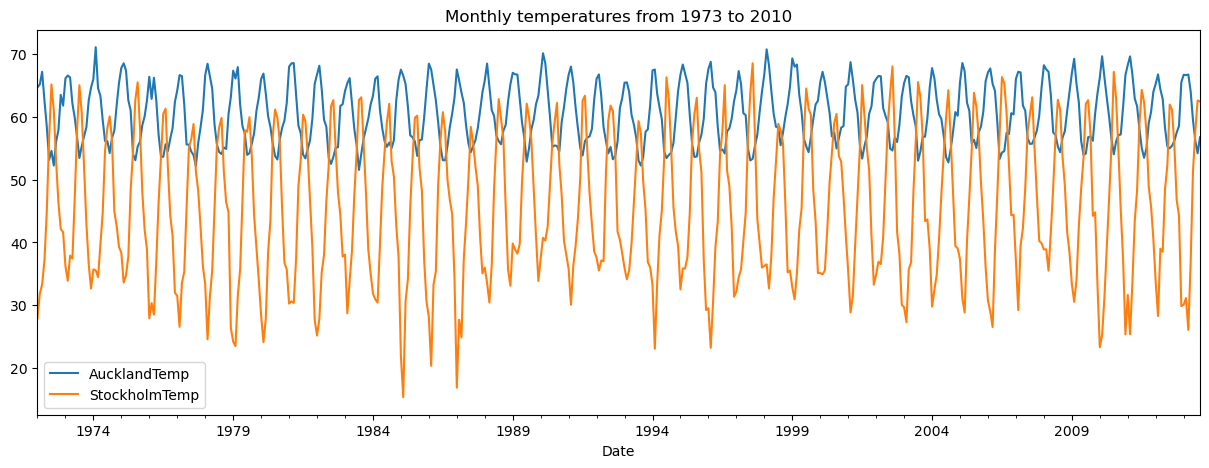

In [23]:
joined_part.plot(figsize=(15, 5))
plt.title("Monthly temperatures from 1973 to 2010");

## Normalize data

**As you can see from the plot above, the temperature scales are different for Auckland and Stockholm, so it is good idea to 'normalize' the values before running through the VARMA model, using SciKit-Learn `StandardScaler()` function.**

In [24]:
# Create training and test sets

N_test = 12

train = joined_part.iloc[: -N_test].copy()
test = joined_part.iloc[-N_test :].copy()

In [25]:
train.head()

,AucklandTemp,StockholmTemp
Date,,
1972-01-01,64.7312,27.9194
1972-02-01,65.2010,31.8020
1972-03-01,67.2116,33.3140
1972-04-01,62.6378,37.1462
1972-05-01,58.4708,44.9906


In [26]:
# Normalize Auckland training and test data

scaler_auckland = StandardScaler()

train['ScaledAuckland'] = scaler_auckland.fit_transform(train[['AucklandTemp']])

test['ScaledAuckland'] = scaler_auckland.transform(test[['AucklandTemp']])

In [27]:
# Normalize Stockholm training and test data

scaler_stockholm = StandardScaler()

train['ScaledStockholm'] = scaler_stockholm.fit_transform(train[['StockholmTemp']])

test['ScaledStockholm'] = scaler_stockholm.transform(test[['StockholmTemp']])

In [28]:
train.head()

,AucklandTemp,StockholmTemp,ScaledAuckland,ScaledStockholm
Date,,,,
1972-01-01,64.7312,27.9194,0.912482,-1.491603
1972-02-01,65.2010,31.8020,1.010449,-1.150745
1972-03-01,67.2116,33.3140,1.429716,-1.018004
1972-04-01,62.6378,37.1462,0.475948,-0.681570
1972-05-01,58.4708,44.9906,-0.392990,0.007099


In [29]:
# Boolean index series to add predictions and plot

train_idx = joined_part.index <= train.index[-1]
test_idx = joined_part.index > train.index[-1]

In [30]:
# Put scaled columns back in original data (joined_part)

joined_part.loc[train_idx, 'ScaledAuckland'] = train['ScaledAuckland']
joined_part.loc[test_idx, 'ScaledAuckland'] = test['ScaledAuckland']
joined_part.loc[train_idx, 'ScaledStockholm'] = train['ScaledStockholm']
joined_part.loc[test_idx, 'ScaledStockholm'] = test['ScaledStockholm']

In [31]:
joined_part.head()

,AucklandTemp,StockholmTemp,ScaledAuckland,ScaledStockholm
Date,,,,
1972-01-01,64.7312,27.9194,0.912482,-1.491603
1972-02-01,65.2010,31.8020,1.010449,-1.150745
1972-03-01,67.2116,33.3140,1.429716,-1.018004
1972-04-01,62.6378,37.1462,0.475948,-0.681570
1972-05-01,58.4708,44.9906,-0.392990,0.007099


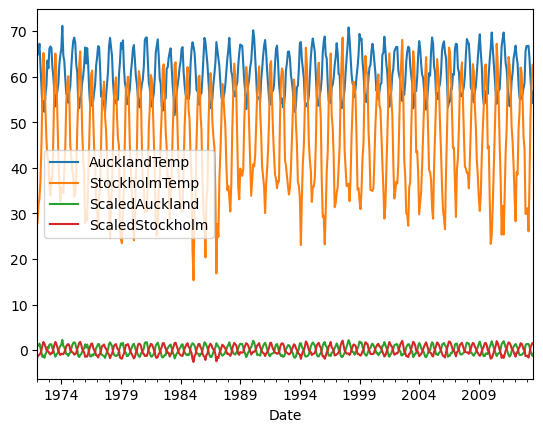

In [32]:
# Plot training set (smaller for ease of viewing)

joined_part.plot();

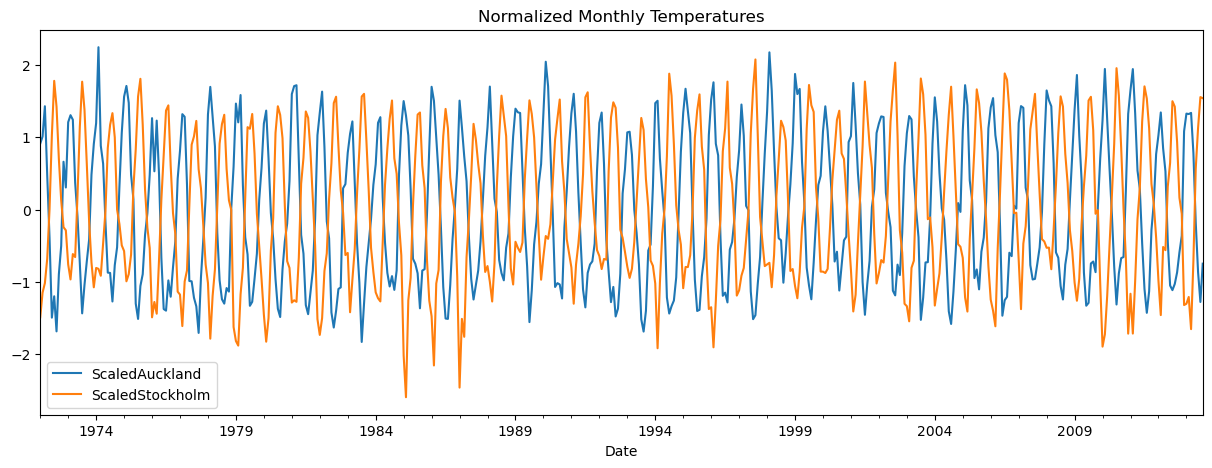

In [33]:
cols = ['ScaledAuckland', 'ScaledStockholm']

joined_part[cols].plot(figsize=(15, 5))
plt.title("Normalized Monthly Temperatures");

## Plot ACF and PACF 

**Now that both time series are normalized to the same scale, you can assess the AR & MA orders for each one through the ACF and PACF plotting functions.** 

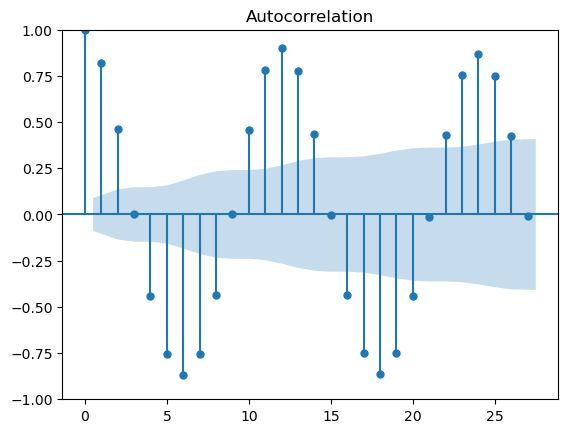

In [34]:
plot_acf(train['ScaledAuckland']);

**Note that the autocorrelation has a strong seasonal pattern, where the highest correlation occurs every 6 timesteps (months). Dates that are three timesteps prior to the current value have the least significance to the current value.**

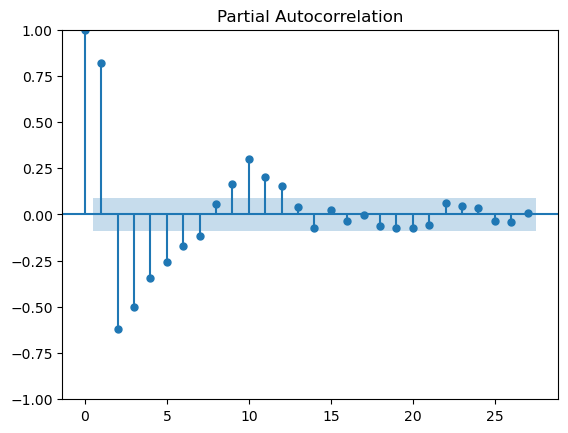

In [37]:
plot_pacf(train['ScaledAuckland']);

**In the partial autocorrelation, the correlation is strongest around the earlier lags, between 1 and 6. These past data points are most significant to the target output.**

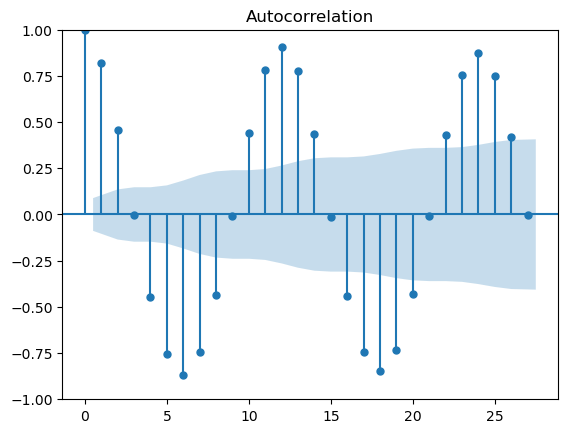

In [35]:
plot_acf(train['ScaledStockholm']);

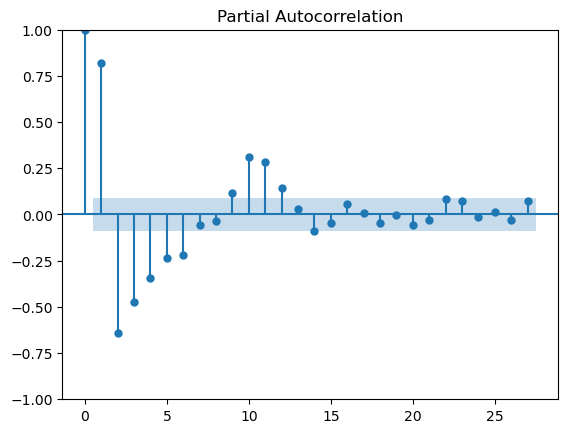

In [36]:
plot_pacf(train['ScaledStockholm']);

**Stockholm has the same correlation behaviour as Auckland, with a strong seasonal component demonstrated by the autocorrelation plot, with the previous 6 values having greatest significance on model prediction as seen in the partial autocorrelation.**

**Using these plots and based on their similarity, it can be estimated that the best orders for both cities are AR(6) and MA(6), but these are not necessarily the correct values - it is just a place to start from.**

## Build `VARMAX` model

**Create a `VARMAX` object and fit it to the time series training set. Include only the 'scaled' columns, and use the `datetime()` function to measure how long the training takes (VARMAX is notoriously slower than pure VAR model).**

**NOTE: If you increase `maxiter` when fitting the model, you may be able to avoid convergence warning messages, but it is unlikely.**

In [37]:
train[cols].head()

,ScaledAuckland,ScaledStockholm
Date,,
1972-01-01,0.912482,-1.491603
1972-02-01,1.010449,-1.150745
1972-03-01,1.429716,-1.018004
1972-04-01,0.475948,-0.681570
1972-05-01,-0.392990,0.007099


In [38]:
t0 = datetime.now()

# Enter p & q order values based on ACF and PACF plots
model = VARMAX(train[cols], order=(6, 6))

res = model.fit(maxiter=300)

print("Duration:", datetime.now() - t0)

C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\varmax.py:161: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
C:\Users\shmel\Anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Duration: 0:00:52.590648


In [39]:
# Generate test predictions and confidence intervals

fcast = res.get_forecast(N_test)

In [40]:
# Access confidence intervals from PredictionResults object

fcast.conf_int() 

,lower ScaledAuckland,lower ScaledStockholm,upper ScaledAuckland,upper ScaledStockholm
2012-09-01,-1.498168,0.378127,-0.461083,1.439087
2012-10-01,-1.088193,-0.229561,0.001680,0.888757
2012-11-01,-0.457572,-0.948809,0.641148,0.176371
2012-12-01,0.198630,-1.416518,1.301182,-0.288105
2013-01-01,0.786410,-1.810622,1.901384,-0.679617
2013-02-01,0.914064,-1.768020,2.034571,-0.631624
2013-03-01,0.635652,-1.632278,1.759412,-0.495024
2013-04-01,-0.099617,-1.055521,1.036662,0.091627
2013-05-01,-0.867484,-0.322749,0.273169,0.828899
2013-06-01,-1.497992,0.443301,-0.354022,1.599486


In [41]:
# Access test predictions from PredictionResults object

fcast.predicted_mean

,ScaledAuckland,ScaledStockholm
2012-09-01,-0.979625,0.908607
2012-10-01,-0.543256,0.329598
2012-11-01,0.091788,-0.386219
2012-12-01,0.749906,-0.852312
2013-01-01,1.343897,-1.245119
2013-02-01,1.474317,-1.199822
2013-03-01,1.197532,-1.063651
2013-04-01,0.468523,-0.481947
2013-05-01,-0.297157,0.253075
2013-06-01,-0.926007,1.021393


In [42]:
# Generate training predictions with Results object

res.fittedvalues['ScaledAuckland']

Date
1972-01-01   -0.006053
1972-02-01    0.959013
1972-03-01    0.744948
1972-04-01    0.804442
1972-05-01   -0.093554
                ...   
2012-04-01    0.612693
2012-05-01   -0.370915
2012-06-01   -0.903898
2012-07-01   -1.274175
2012-08-01   -1.137168
Freq: MS, Name: ScaledAuckland, Length: 488, dtype: float64

## Plot predictions against scaled data

In [43]:
# Add training and test predictions to original data for Auckland

joined_part.loc[train_idx, 'Train Pred Auckland'] = res.fittedvalues['ScaledAuckland']

joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast.predicted_mean['ScaledAuckland']

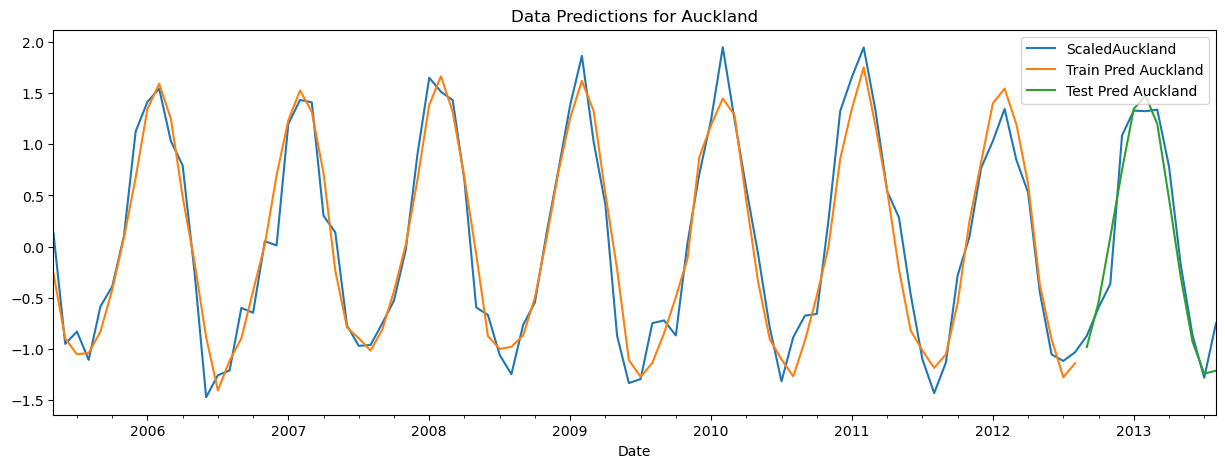

In [44]:
plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']

# Plot last 100 rows only to view more closely
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5))
plt.title("VARMA Data Predictions for Auckland");

In [45]:
# Add training and test predictions to original data for Stockholm

joined_part.loc[train_idx, 'Train Pred Stockholm'] = res.fittedvalues['ScaledStockholm']

joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast.predicted_mean['ScaledStockholm']

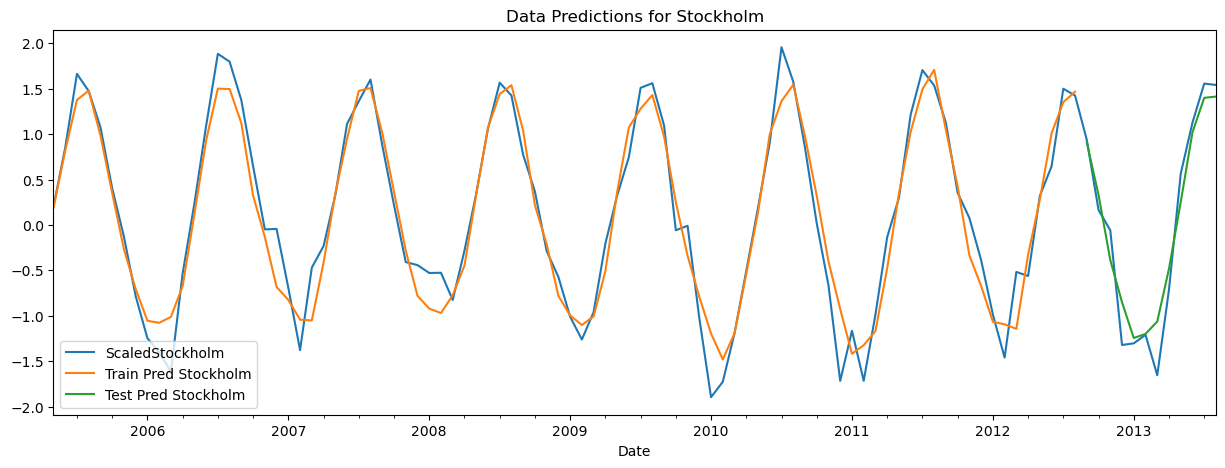

In [46]:
plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']

# Plot last 100 rows to view more closely
joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5))
plt.title("VARMA Data Predictions for Stockholm");

**Both predictions for Auckland and Stockholm match the true values quite closely, so the model seems to be performing very well for both time series.**

## Compute R-Squared metric for each time series

In [49]:
joined_part.head()

,AucklandTemp,StockholmTemp,ScaledAuckland,ScaledStockholm,Train Pred Auckland,Test Pred Auckland,Train Pred Stockholm,Test Pred Stockholm
Date,,,,,,,,
1972-01-01,64.7312,27.9194,0.912482,-1.491603,-0.006053,NaN,-0.004010,NaN
1972-02-01,65.2010,31.8020,1.010449,-1.150745,0.959013,NaN,-1.170964,NaN
1972-03-01,67.2116,33.3140,1.429716,-1.018004,0.744948,NaN,-0.762609,NaN
1972-04-01,62.6378,37.1462,0.475948,-0.681570,0.804442,NaN,-0.664346,NaN
1972-05-01,58.4708,44.9906,-0.392990,0.007099,-0.093554,NaN,0.064517,NaN


In [47]:
# Training R2 for Auckland
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']
print("Auckland Train R2:", round(r2_score(y_true, y_pred), 3))

# Test R2 for Auckland
y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']
y_true = joined_part.loc[test_idx, 'ScaledAuckland']
print("Auckland Test R2:", round(r2_score(y_true, y_pred), 3))

Auckland Train R2: 0.926
Auckland Test R2: 0.937


In [48]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']
print("Stockholm Train R2:", round(r2_score(y_true, y_pred), 3))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']
print("Stockholm Test R2:", round(r2_score(y_true, y_pred), 3))

Stockholm Train R2: 0.922
Stockholm Test R2: 0.941


**The VARMA model performs well on both time series, with closely-matched predictions and R-Squared score based on the test set. Visually, it seemed that Stockholm data had more anomalies and randomness introduced by some sudden drops in temperature, but the R-Squared scores are evenly matched between cities.**

**In real-world scenario, you should also perform naive forecasting to confirm whether this model is indeed the better option.**

# Compare to VAR model

**The pure VAR model is more popular than VARMA and VMA models, because it is faster to train. However, the `p` order for AutoRegression is determined by specifying the maximmum nmber of lags allowed through the `maxlag` argument, taken from the model object already created when instantiating the model with `VAR()` function.**

**Once the model has tested all possible lag values against each information criterion, you can access the results by calling `selected_orders` attribute off the model object.**

In [50]:
model = VAR(train[cols])

In [51]:
# Arbitrary max value of 15 lags chosen
lag_order_results = model.select_order(maxlags=15)

lag_order_results

In [52]:
# Note that they do not all agree - BIC is half as much

lag_order_results.selected_orders

{'aic': 12, 'bic': 6, 'hqic': 11, 'fpe': 12}

In [53]:
# Specify information metric and maxlags when training VAR model

results = model.fit(maxlags=15, ic='aic')

**When forecasting with VAR, you need to pass the previous values in the time series, as well as specifying the number of timesteps following the end of the training set. The number of previous values is determined by the lag order used by the model.**

In [54]:
# Access optimum p lag value

lag_order = results.k_ar

In [55]:
lag_order

12

In [56]:
# Convert previous values to NumPy array

prior = train.iloc[-lag_order:][cols].to_numpy()

fcast = results.forecast(prior, N_test)

In [57]:
# NumPy array returned, instead of Results object

fcast

array([[-0.86491205,  0.9126215 ],
       [-0.46098815,  0.41187248],
       [ 0.06315052, -0.18716887],
       [ 0.67626557, -0.76482676],
       [ 1.14208172, -1.07130218],
       [ 1.22700523, -1.0937979 ],
       [ 0.9794002 , -0.80403685],
       [ 0.41338843, -0.40868501],
       [-0.20952007,  0.21598454],
       [-0.78821337,  0.85620681],
       [-1.10693186,  1.24994289],
       [-1.13507881,  1.24097996]])

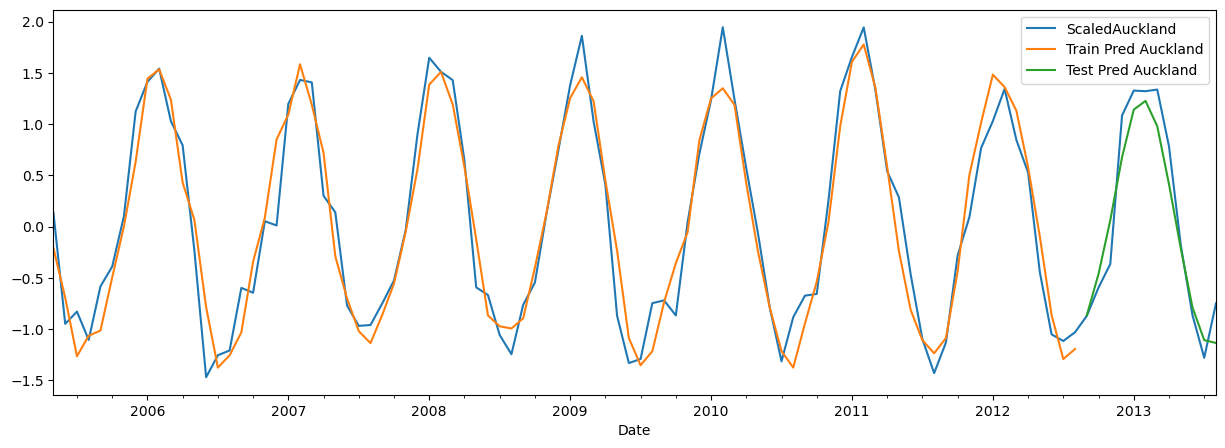

In [58]:
# Add Auckland training and test predictions to original data and plot

joined_part.loc[train_idx, 'Train Pred Auckland'] = results.fittedvalues['ScaledAuckland']
joined_part.loc[test_idx, 'Test Pred Auckland'] = fcast[:,0]

plot_cols = ['ScaledAuckland', 'Train Pred Auckland', 'Test Pred Auckland']

joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

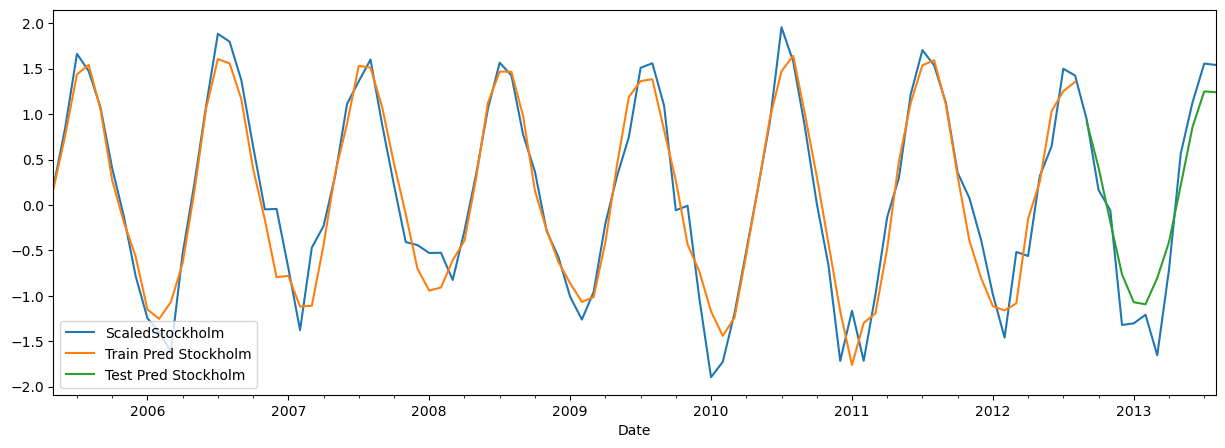

In [59]:
# Add Stockhold training and test predictions to original data and plot

joined_part.loc[train_idx, 'Train Pred Stockholm'] = results.fittedvalues['ScaledStockholm']
joined_part.loc[test_idx, 'Test Pred Stockholm'] = fcast[:,1]

plot_cols = ['ScaledStockholm', 'Train Pred Stockholm', 'Test Pred Stockholm']

joined_part.iloc[-100:][plot_cols].plot(figsize=(15, 5));

**Both Auckand and Stockholm predictions match the true data fairly closely, maybe Auckland more so, and the model appears to be performing as well as the VARMA model.**

## Compute R-squared metric 

In [64]:
y_pred = joined_part.loc[train_idx, 'Train Pred Auckland']
y_true = joined_part.loc[train_idx, 'ScaledAuckland']

y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]

print("Auckland Train R2:", round(r2_score(y_true, y_pred), 3))

In [66]:
y_pred = joined_part.loc[test_idx, 'Test Pred Auckland']

y_true = joined_part.loc[test_idx, 'ScaledAuckland']

print("Auckland Test R2:", round(r2_score(y_true, y_pred), 3))

Auckland Test R2: 0.923


In [67]:
y_pred = joined_part.loc[train_idx, 'Train Pred Stockholm']
y_true = joined_part.loc[train_idx, 'ScaledStockholm']

y_true = y_true.iloc[lag_order:]
y_pred = y_pred.iloc[lag_order:]

print("Stockholm Train R2:", round(r2_score(y_true, y_pred), 3))

y_pred = joined_part.loc[test_idx, 'Test Pred Stockholm']
y_true = joined_part.loc[test_idx, 'ScaledStockholm']

print("Stockholm Test R2:", round(r2_score(y_true, y_pred), 3))

Stockholm Train R2: 0.927
Stockholm Test R2: 0.893


**As expected, the Auckland temperature predictions accuracy is a little bit higher than Stockholm's. The model is quite good, although not as good as VARMA model performance.**

# Establish baseline using `ARIMA`

**You can use pure ARIMA to establish a baseline performance for each time series (without any differencing).**

In [69]:
from statsmodels.tsa.arima.model import ARIMA

In [74]:
for col in cols:
    model = ARIMA(train[col], order=(10, 0, 10)) 
    res = model.fit(method_kwargs={'maxiter':500}) 
    fcast = res.get_forecast(N_test)
    
    print(f"{col} Train R^2:", r2_score(joined_part.loc[train_idx, col], res.fittedvalues))
    print(f"{col} Test R^2:", r2_score(joined_part.loc[test_idx, col], fcast.predicted_mean))

ScaledAuckland Train R^2: 0.9225106443795407
ScaledAuckland Test R^2: 0.9416071373303392
ScaledStockholm Train R^2: 0.9225860297429477
ScaledStockholm Test R^2: 0.93468323356824


**The ARIMA model has higher accuracy scores than the VARMA or VAR model, which means it is overfitting less than the VARMA or VAR models, probably because it has eliminated any cross-terms in vectored model. It appears that the baseline is the best choice.**

**EXERCISE: Use Seasonal ARIMA for a more 'parsimonious' model (`SARIMAX()` in StatsModel API).**